## Libraries needed

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from numpy import where
import collections
from collections import Counter
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import KFold
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

### In this notebook

We will load, clean, and select all the groups of files that we have collected about household information for Argentina from 2015 to 2020. We will be manipulation 3 datasets, one from 2015, another one from 2017 and the third one from 2020.

## 1. Loading the data

In [2]:
h15 = pd.read_excel('/Users/mac/Desktop/TFG/data/tables/ARG/household/2015/EPH_usu_2doTrim_2015_xls/usu_hogar_T215.xls')  
h17 = pd.read_excel('/Users/mac/Desktop/TFG/data/tables/ARG/household/2017/data/usu_hogar_t117.xlsx')  
h20 = pd.read_excel('/Users/mac/Desktop/TFG/data/tables/ARG/household/2020/EPH_usu_4_Trim_2020_xls/EPH_usu_personas_4to.trim2020.xls.xlsx')  

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


We will only be using the following variables:

IV1: House type

IV2: Number of rooms

IV6: Water availability

IV8: Bathroom

IV9: Water closset location

IV12_1: Nearby dump

II2: Total bedrooms

II4_1: Kitchen

II4_3: Garage

V1: Import earned at work

V6: Import earned from clothes, food, charity, etc.

ITF: Total family income

IPCF: Total income per family capita 

AGLOMERADO: Chipboard code


In [3]:
#Select the variables which are relevant for the study
var15 = h15[['IV1', 'IV2','IV6','IV8', 'IV9','IV12_1', 'II2','II4_1', 'II4_3','V1', 'ITF', 'IPCF','AGLOMERADO']]
var17 = h17[['IV1', 'IV2','IV6','IV8', 'IV9','IV12_1', 'II2','II4_1', 'II4_3','V1', 'ITF', 'IPCF','AGLOMERADO']]
var20 = h20[['IV1', 'IV2','IV6','IV8', 'IV9','IV12_1', 'II2','II4_1', 'II4_3','V1', 'ITF', 'IPCF','AGLOMERADO']]

## 2. Cleaning of datasets
Now that we have selected the relevant variables for the study, lets clean our data

In [4]:
#Checking for no valuable data
var15.describe()

,IV1,IV2,IV6,IV8,IV9,IV12_1,II2,II4_1,II4_3,V1,ITF,IPCF,AGLOMERADO
count,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000,18796.000000
mean,1.219089,3.064961,1.024526,1.002607,1.032081,1.929293,1.901628,1.046446,1.691530,1.199936,12710.844648,5088.331225,24.113748
std,0.461891,2.207338,0.160753,0.050993,0.190720,0.256341,0.856290,0.216683,0.464745,0.410985,14691.192613,6315.800800,18.623785
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3000.000000,1000.000000,10.000000
50%,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,10000.000000,3750.000000,23.000000
75%,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,18000.000000,7000.000000,33.000000
max,6.000000,99.000000,3.000000,2.000000,3.000000,2.000000,10.000000,2.000000,2.000000,9.000000,718000.000000,239333.330000,93.000000


In [5]:
#Check for null values
var15_null = var15.isnull().sum()
var17_null = var17.isnull().sum()
var20_null = var20.isnull().sum()
print(pd.concat([var15_null, var17_null, var20_null], axis=1, keys=['var15', 'var17', 'var20']))

            var15  var17  var20
IV1             0      0      0
IV2             0      0      0
IV6             0      0      0
IV8             0      0      0
IV9             0      0      0
IV12_1          0      0      0
II2             0      0      0
II4_1           0      0      0
II4_3           0      0      0
V1              0      0      0
ITF             0      0      0
IPCF            0      0      0
AGLOMERADO      0      0      0


In [6]:
#Check variable data types for later manipulation
var15.dtypes

IV1             int64
IV2             int64
IV6             int64
IV8             int64
IV9             int64
IV12_1          int64
II2             int64
II4_1           int64
II4_3           int64
V1              int64
ITF             int64
IPCF          float64
AGLOMERADO      int64
dtype: object

All our data is valuable

## 3.Data Exploration
We will now explore the correlation of our data per year, dropping those variables with a correlation >0.85

                 IV1       IV2       IV6       IV8       IV9    IV12_1  \
IV1         1.000000 -0.117548  0.024363  0.023187  0.012617  0.036475   
IV2        -0.117548  1.000000 -0.074214 -0.039320 -0.055631 -0.000533   
IV6         0.024363 -0.074214  1.000000  0.173938  0.482808 -0.065080   
IV8         0.023187 -0.039320  0.173938  1.000000 -0.276669 -0.002179   
IV9         0.012617 -0.055631  0.482808 -0.276669  1.000000 -0.067870   
IV12_1      0.036475 -0.000533 -0.065080 -0.002179 -0.067870  1.000000   
II2        -0.188992  0.290701 -0.060936 -0.042867 -0.032801 -0.045021   
II4_1       0.053020 -0.050582  0.170448  0.066086  0.123588 -0.057735   
II4_3       0.200586 -0.135179  0.092728  0.031689  0.085243 -0.024097   
V1          0.052318 -0.019772 -0.017855 -0.007101 -0.024818  0.049349   
ITF        -0.012179  0.084214 -0.050240 -0.021974 -0.046733  0.015180   
IPCF        0.089185  0.014351 -0.060988 -0.021444 -0.061958  0.055342   
AGLOMERADO  0.028468 -0.024907 -0.0042

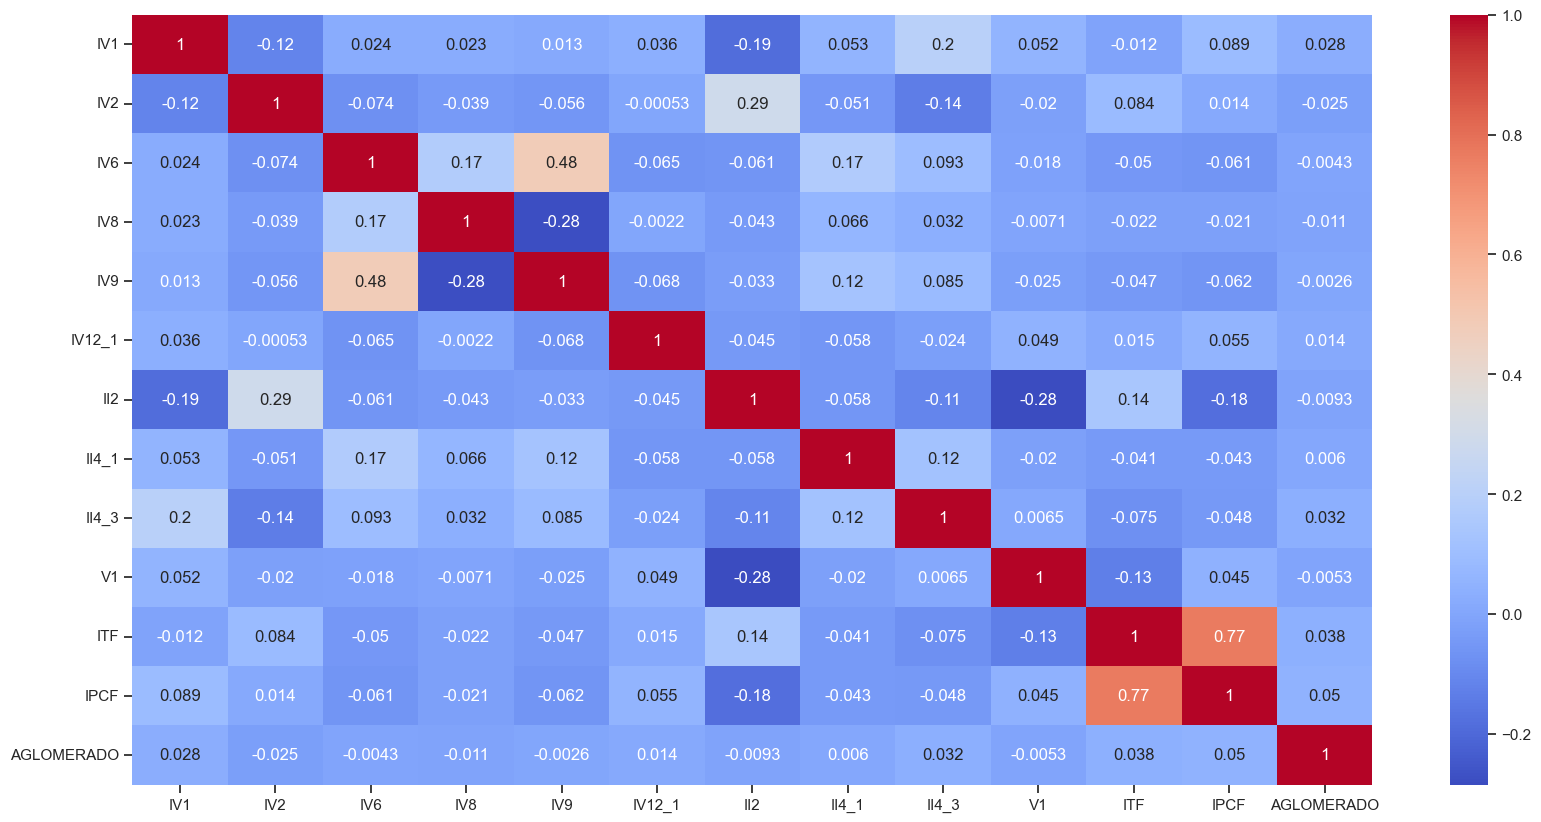

In [7]:
#2015
print(var15.corr())
sns.set(style="ticks")
plt.figure(figsize=(20,10))
sns.heatmap(var15.corr(), annot=True, cmap='coolwarm')
plt.show()

                 IV1       IV2       IV6       IV8       IV9    IV12_1  \
IV1         1.000000 -0.090394  0.041686  0.053432  0.034451  0.045842   
IV2        -0.090394  1.000000 -0.061174 -0.037492 -0.044872  0.001886   
IV6         0.041686 -0.061174  1.000000  0.150916  0.466495 -0.087737   
IV8         0.053432 -0.037492  0.150916  1.000000 -0.308113 -0.012927   
IV9         0.034451 -0.044872  0.466495 -0.308113  1.000000 -0.073292   
IV12_1      0.045842  0.001886 -0.087737 -0.012927 -0.073292  1.000000   
II2        -0.195960  0.249462 -0.065117 -0.044562 -0.040681 -0.037272   
II4_1       0.068382 -0.048015  0.147103  0.056963  0.132905 -0.061427   
II4_3       0.194019 -0.122742  0.090259  0.028474  0.087569 -0.008185   
V1          0.034530 -0.014527 -0.017785  0.000956 -0.021821  0.044854   
ITF        -0.005370  0.079137 -0.049291 -0.026495 -0.046998  0.020005   
IPCF        0.094958  0.014541 -0.055662 -0.022462 -0.054995  0.042882   
AGLOMERADO  0.022128 -0.027393 -0.0024

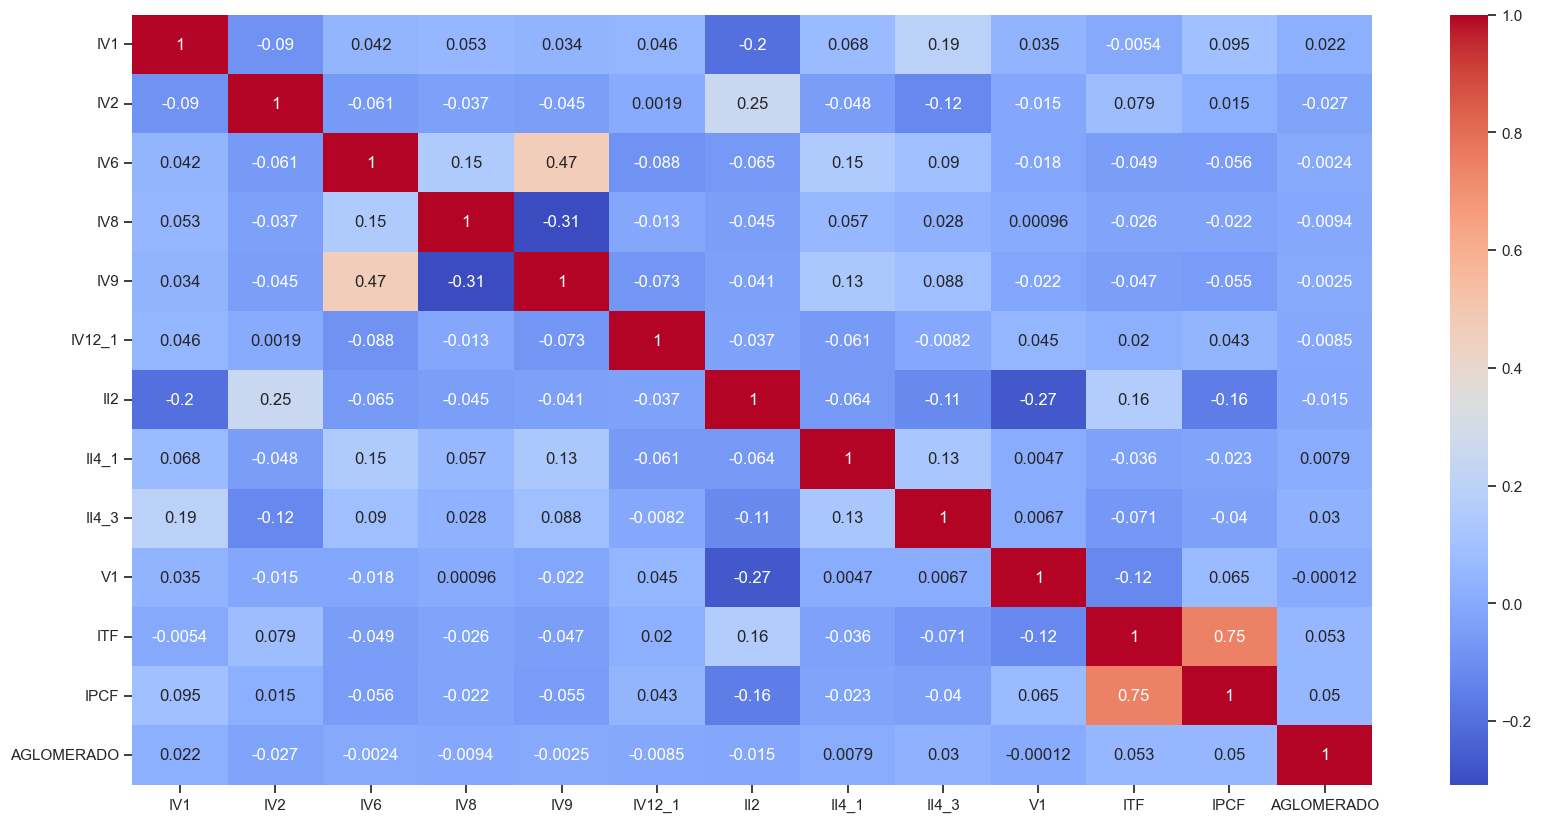

In [8]:
#2017
print(var17.corr())
sns.set(style="ticks")
plt.figure(figsize=(20,10))
sns.heatmap(var17.corr(), annot=True, cmap='coolwarm')
plt.show()

                 IV1       IV2       IV6       IV8       IV9    IV12_1  \
IV1         1.000000 -0.114841  0.071582  0.039283  0.047960  0.053781   
IV2        -0.114841  1.000000 -0.067945  0.016354 -0.066100 -0.029955   
IV6         0.071582 -0.067945  1.000000  0.201502  0.387896 -0.054535   
IV8         0.039283  0.016354  0.201502  1.000000 -0.299087 -0.002917   
IV9         0.047960 -0.066100  0.387896 -0.299087  1.000000 -0.079675   
IV12_1      0.053781 -0.029955 -0.054535 -0.002917 -0.079675  1.000000   
II2        -0.189978  0.294658 -0.061757 -0.047631 -0.048930 -0.042995   
II4_1       0.044478 -0.055615  0.110504  0.068618  0.083329 -0.030366   
II4_3       0.187096 -0.131061  0.081525  0.037050  0.074283 -0.042692   
V1          0.027215 -0.032251 -0.007457 -0.015990 -0.010056  0.048040   
ITF        -0.012055  0.106387 -0.055732 -0.022024 -0.047671  0.007053   
IPCF        0.089464  0.013560 -0.055534 -0.017854 -0.047496  0.042622   
AGLOMERADO  0.002610  0.006505 -0.0068

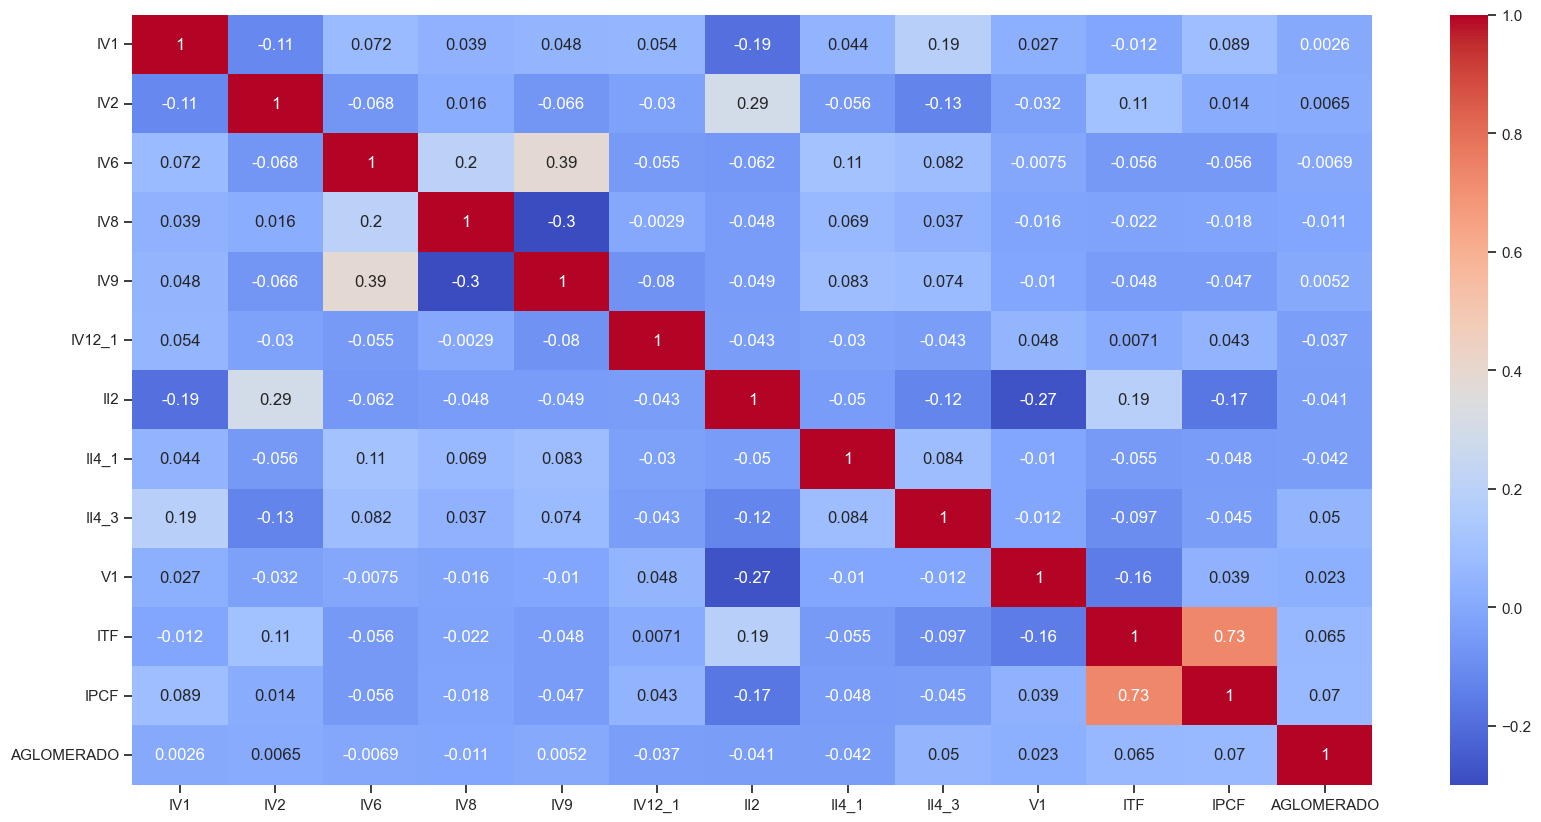

In [9]:
#2020
print(var20.corr())
sns.set(style="ticks")
plt.figure(figsize=(20,10))
sns.heatmap(var20.corr(), annot=True, cmap='coolwarm')
plt.show()

Now we will look for outliers in our 3 datasets and eliminate them

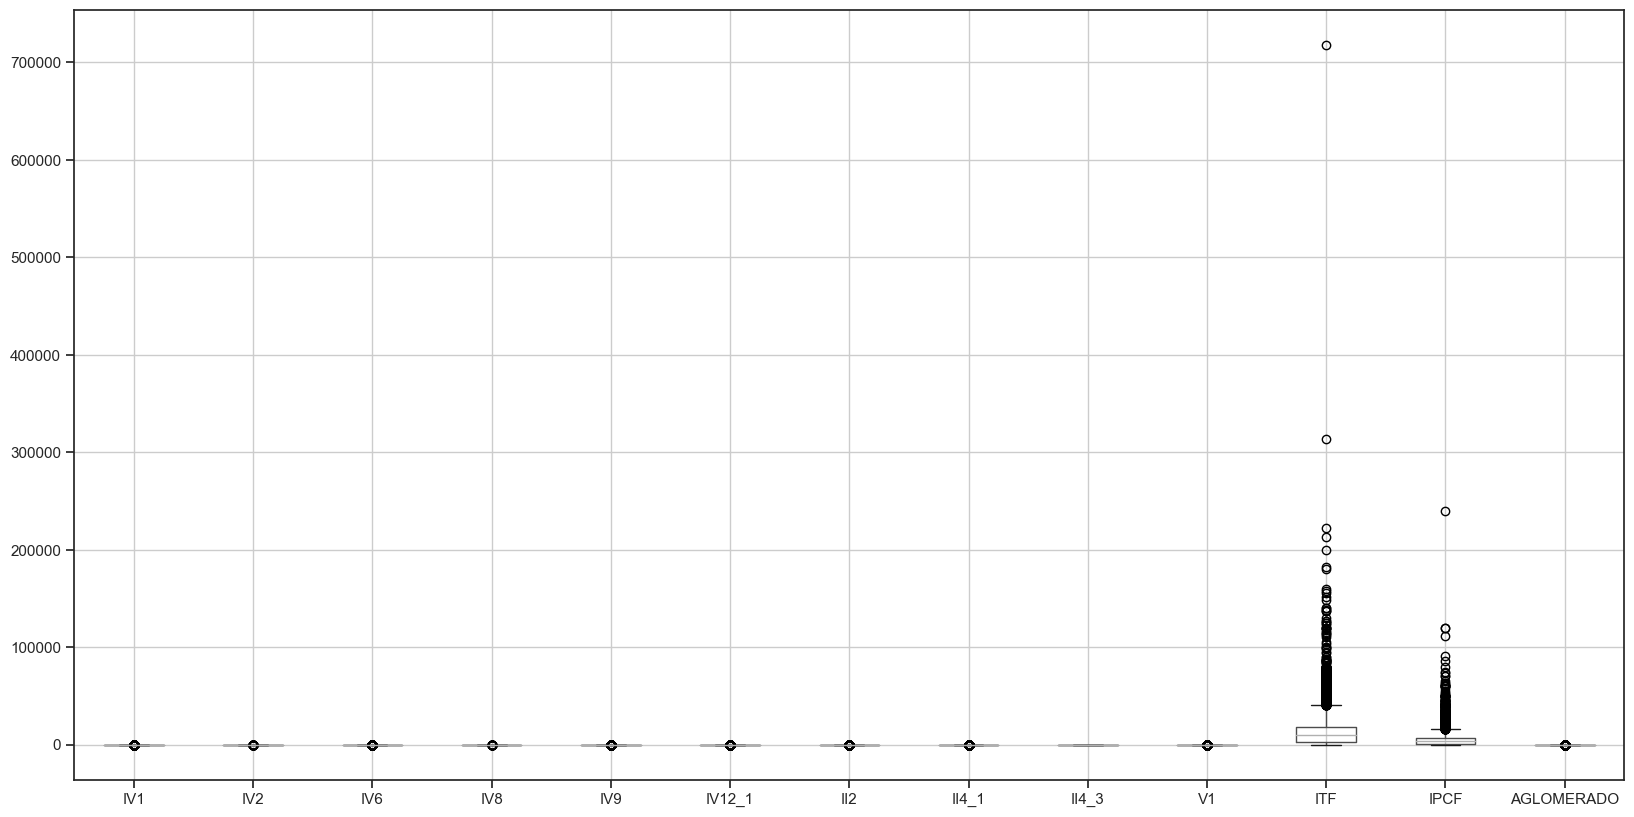

In [10]:
#2015
var15.boxplot(figsize=(20,10))
plt.show()

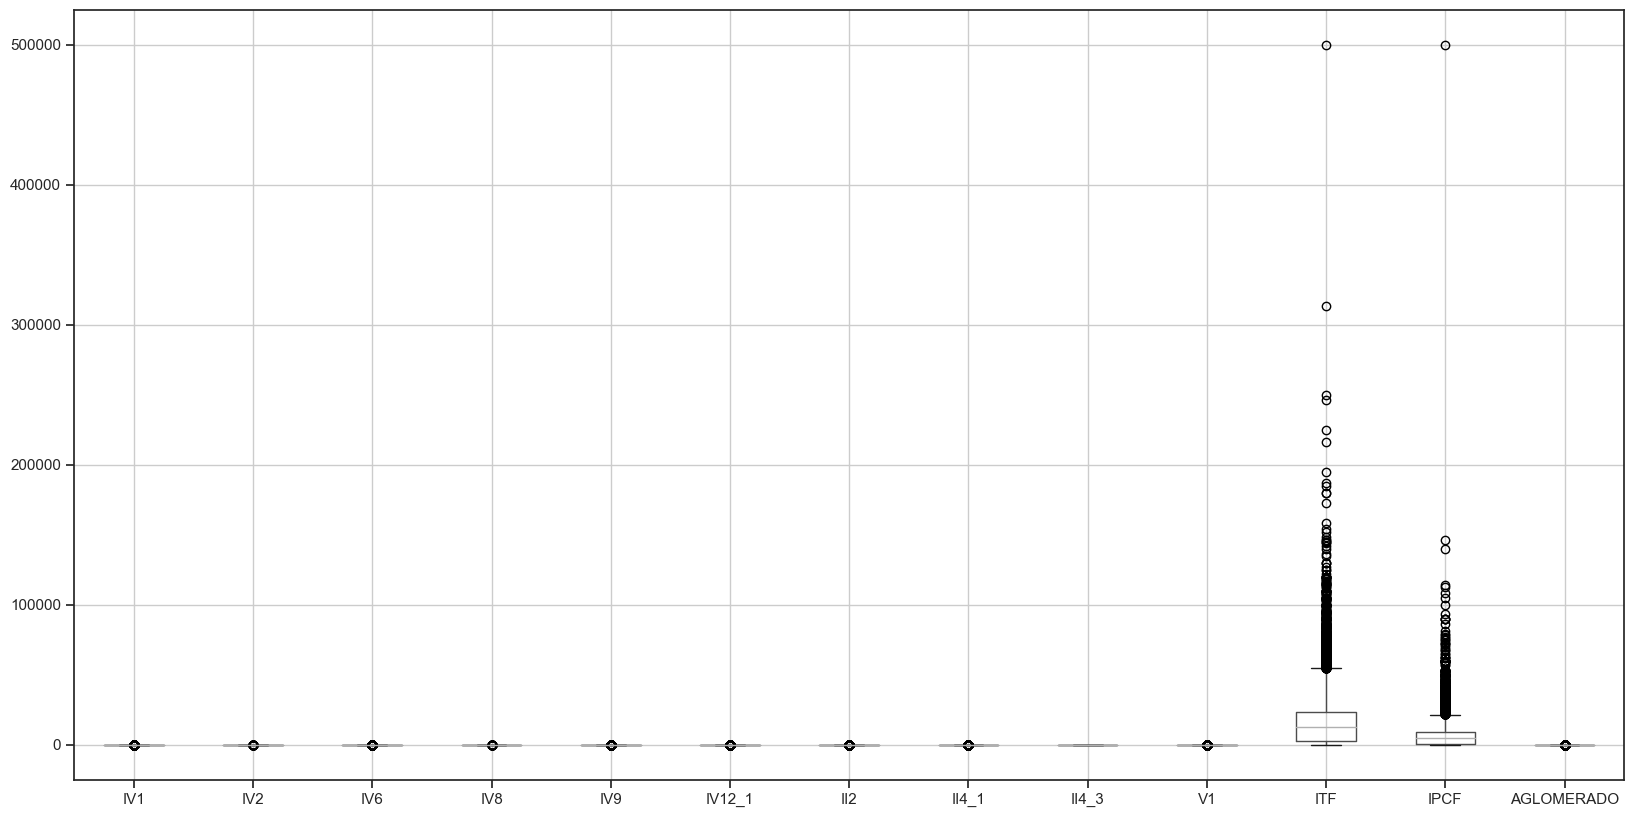

In [11]:
#2017
var17.boxplot(figsize=(20,10))
plt.show()

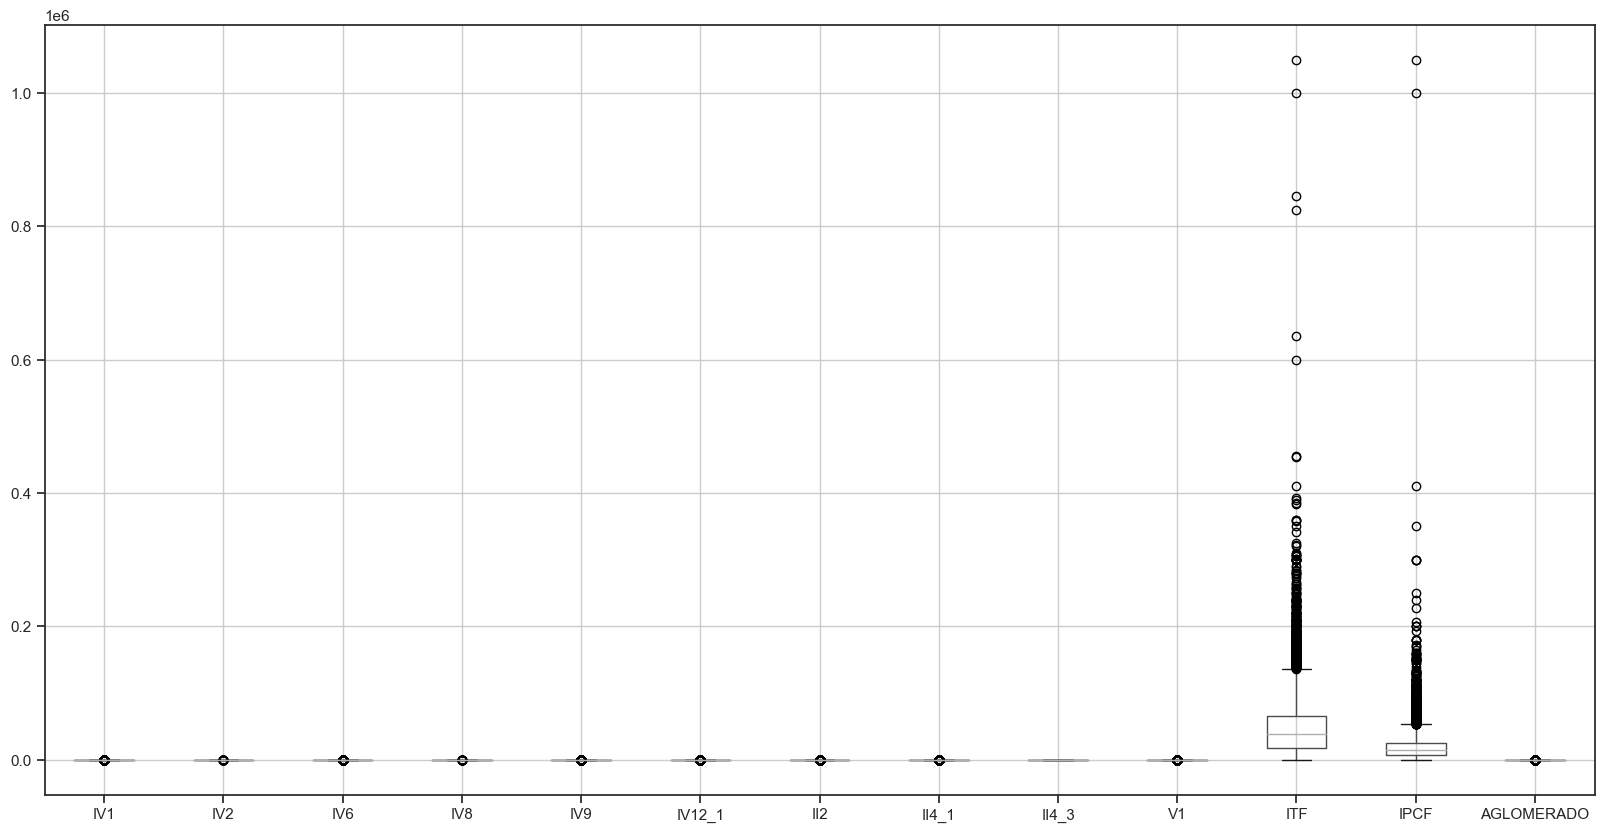

In [12]:
#2020
var20.boxplot(figsize=(20,10))
plt.show()

Remove variables with much larger variation to properly look at the data

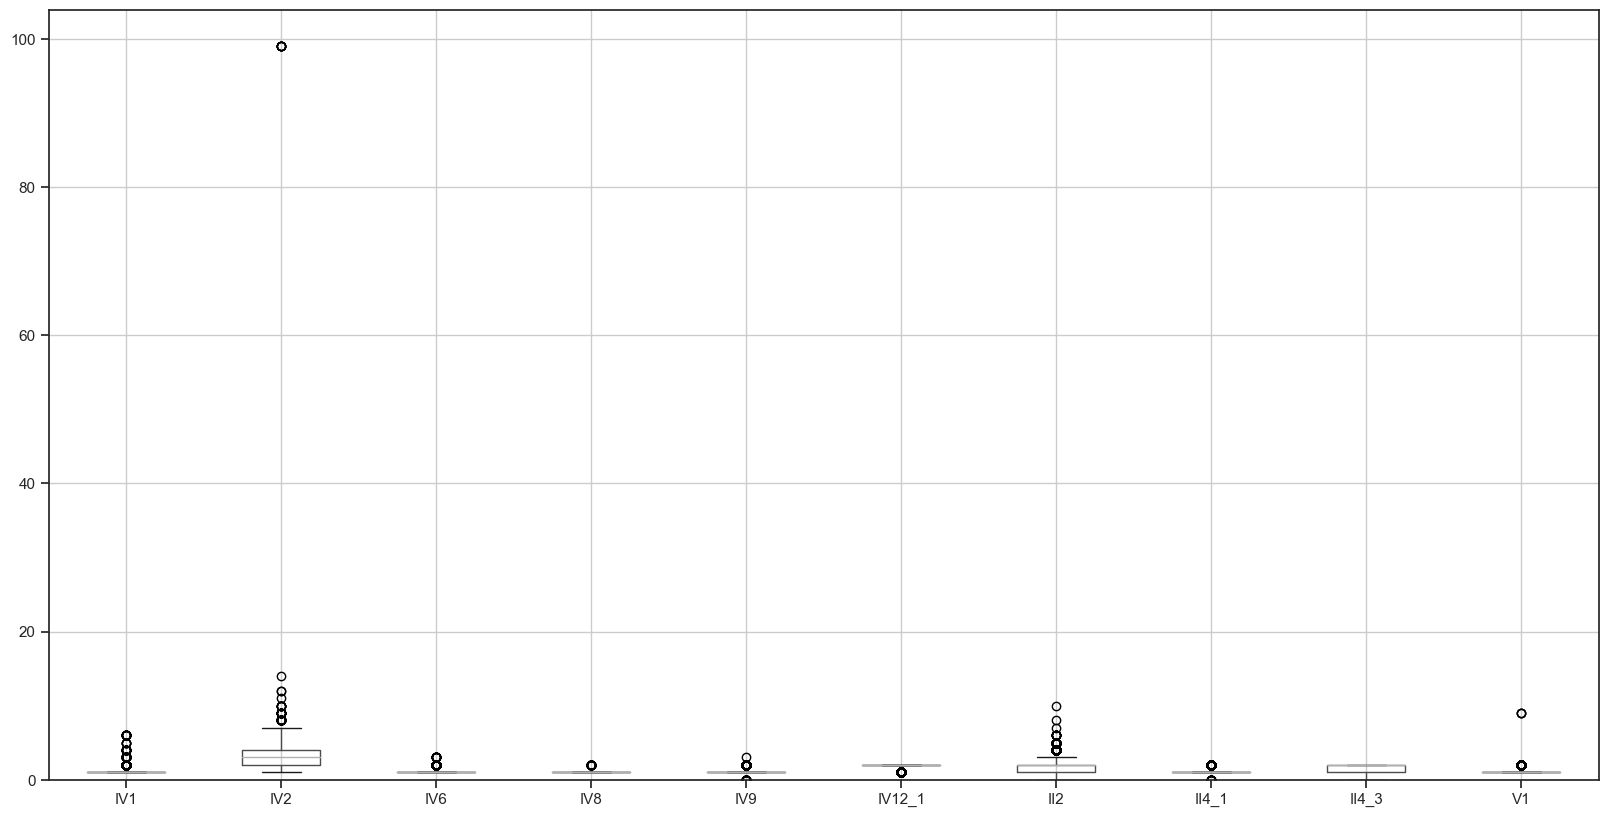

In [13]:
#2015
box_15=var15.drop(['ITF','IPCF','AGLOMERADO'],axis=1)
box_15.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

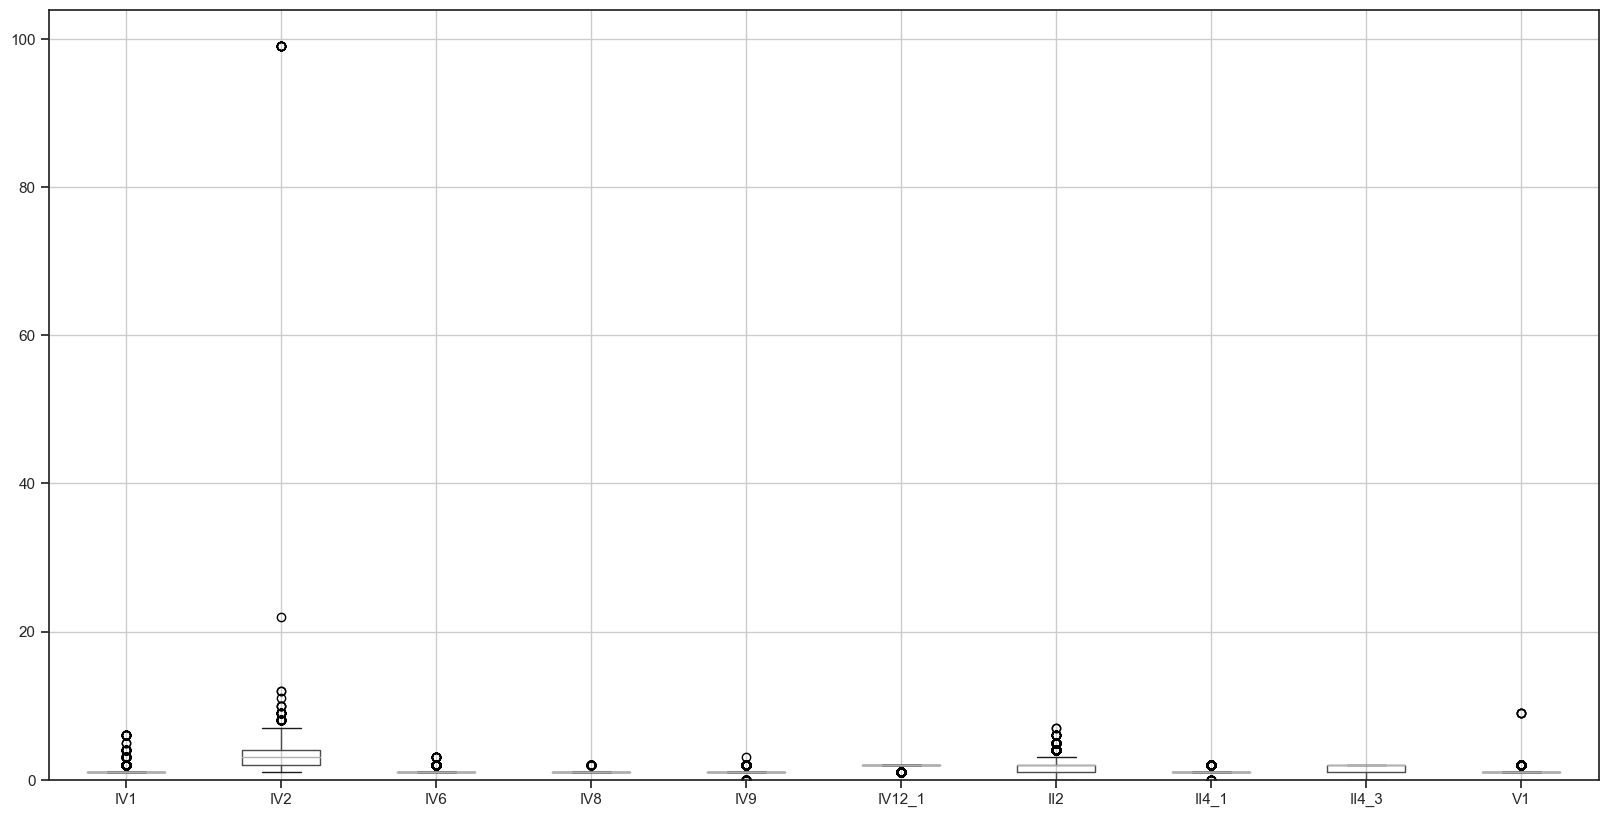

In [14]:
#2017
box_17=var17.drop(['ITF','IPCF','AGLOMERADO'],axis=1)
box_17.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

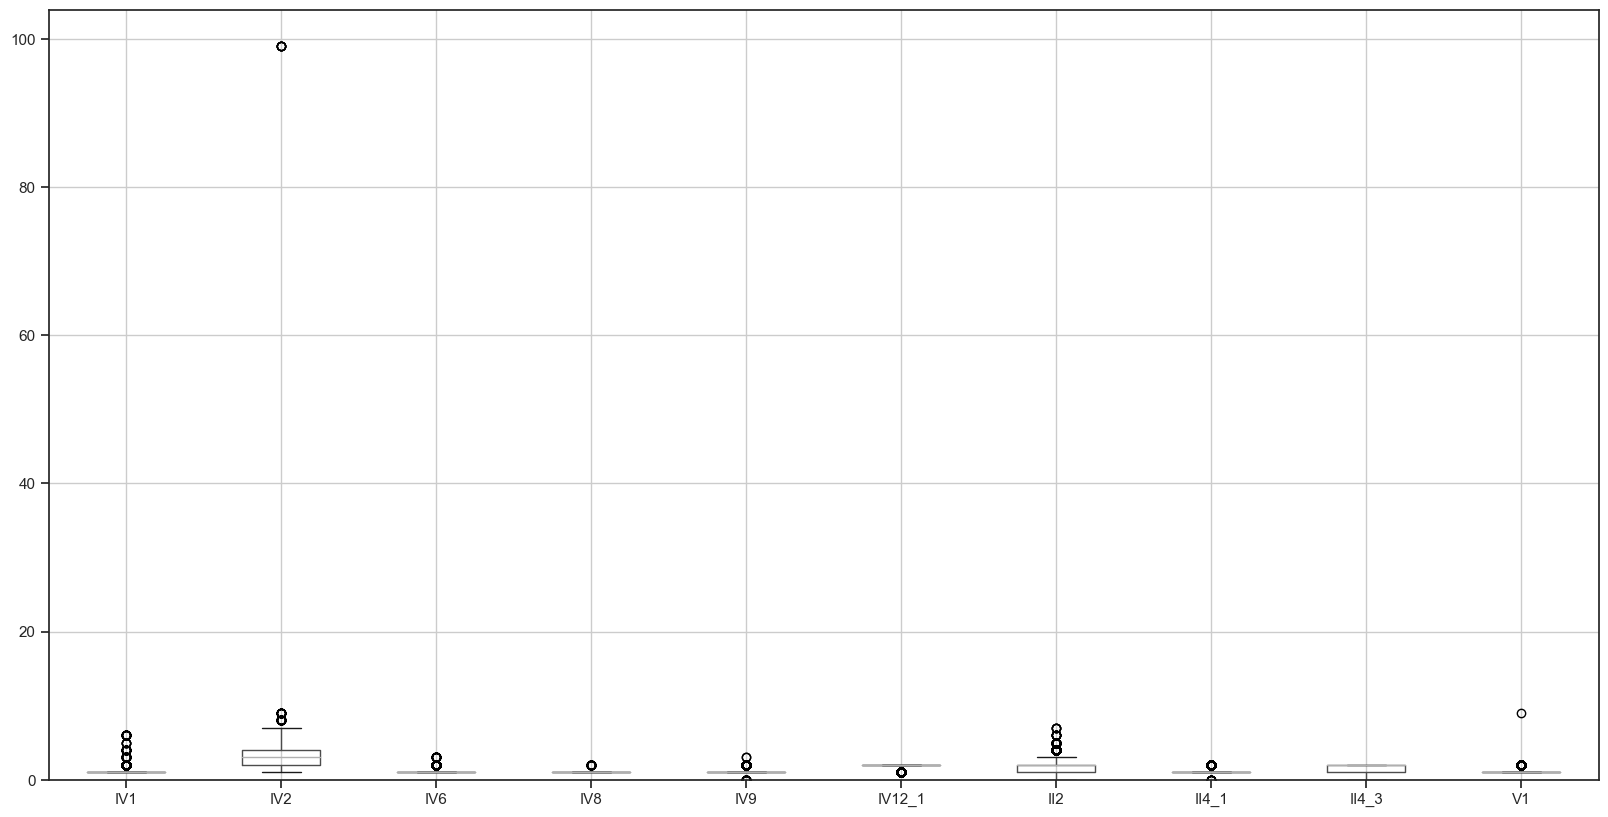

In [15]:
#2020
box_20=var20.drop(['ITF','IPCF','AGLOMERADO'],axis=1)
box_20.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

As we can observe, we have 99 values for number of rooms in a house and as they are not even near the upper quartile, we will remove them

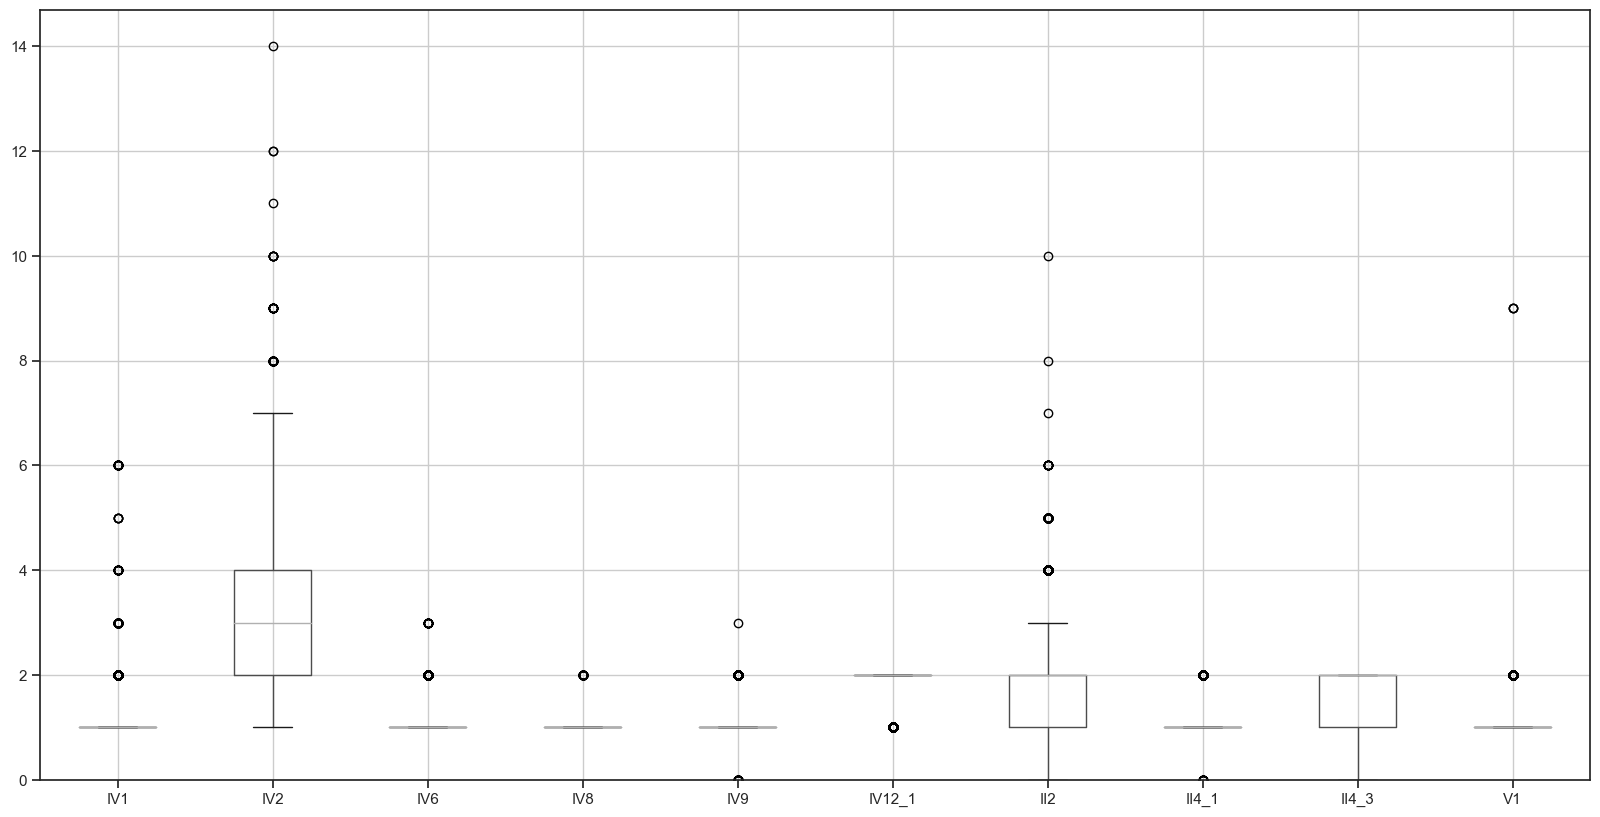

In [16]:
#2015
mean_IV2 = np.mean(var15.loc[var15['IV2'] != 99, 'IV2'])
var15.loc[var15['IV2'] == 99, 'IV2'] = mean_IV2
var15['IV2'].value_counts()
box_15=var15.drop(['ITF','IPCF','AGLOMERADO'],axis=1)
box_15.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

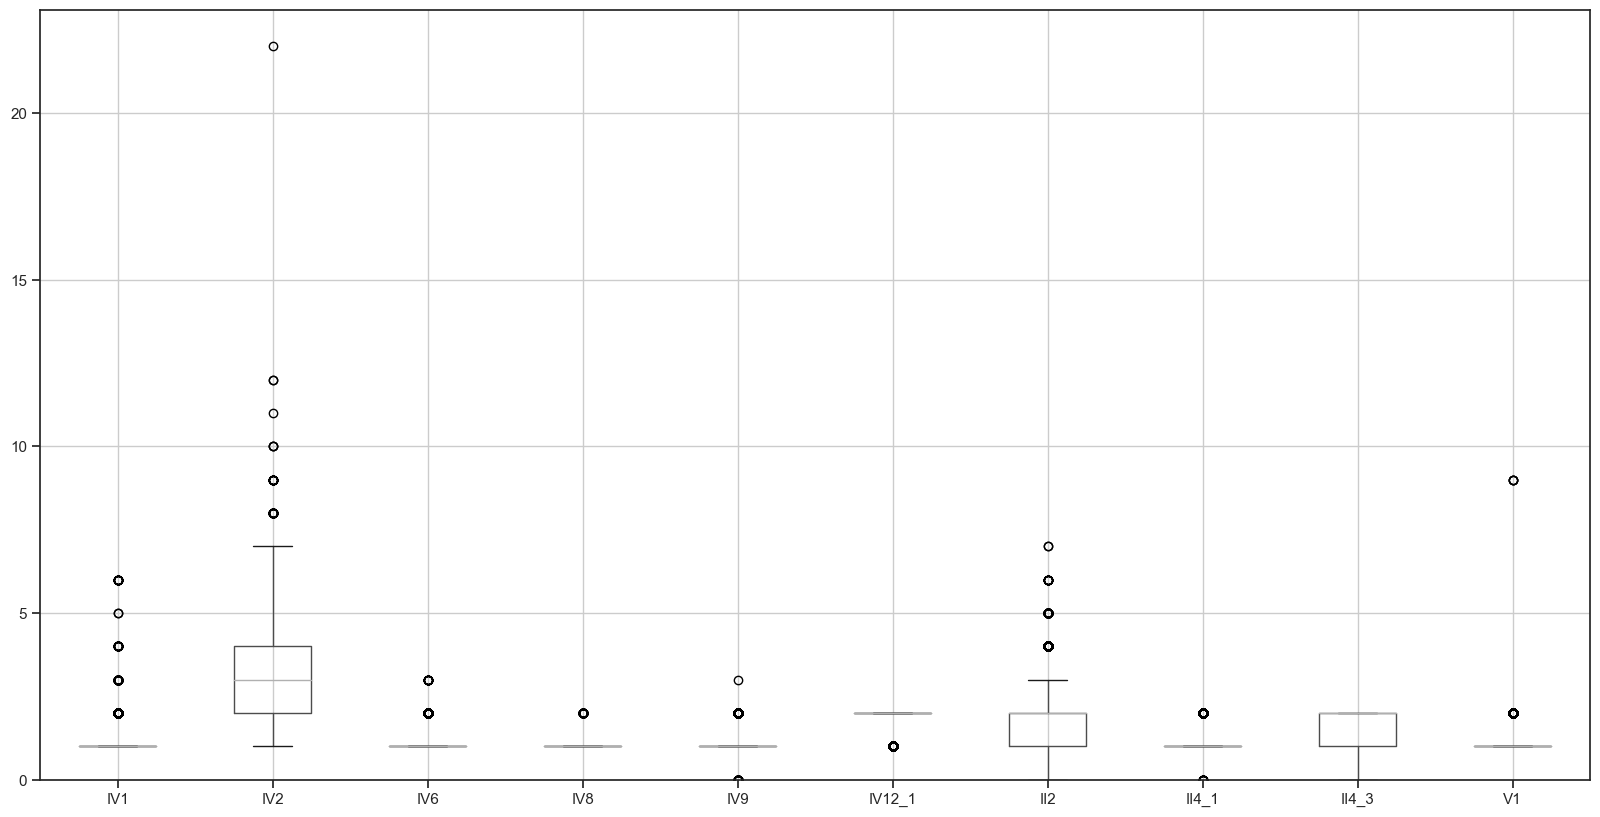

In [17]:
#2017
mean_IV2 = np.mean(var17.loc[var17['IV2'] != 99, 'IV2'])
var17.loc[var17['IV2'] == 99, 'IV2'] = mean_IV2
var17['IV2'].value_counts()
box_17=var17.drop(['ITF','IPCF','AGLOMERADO'],axis=1)
box_17.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

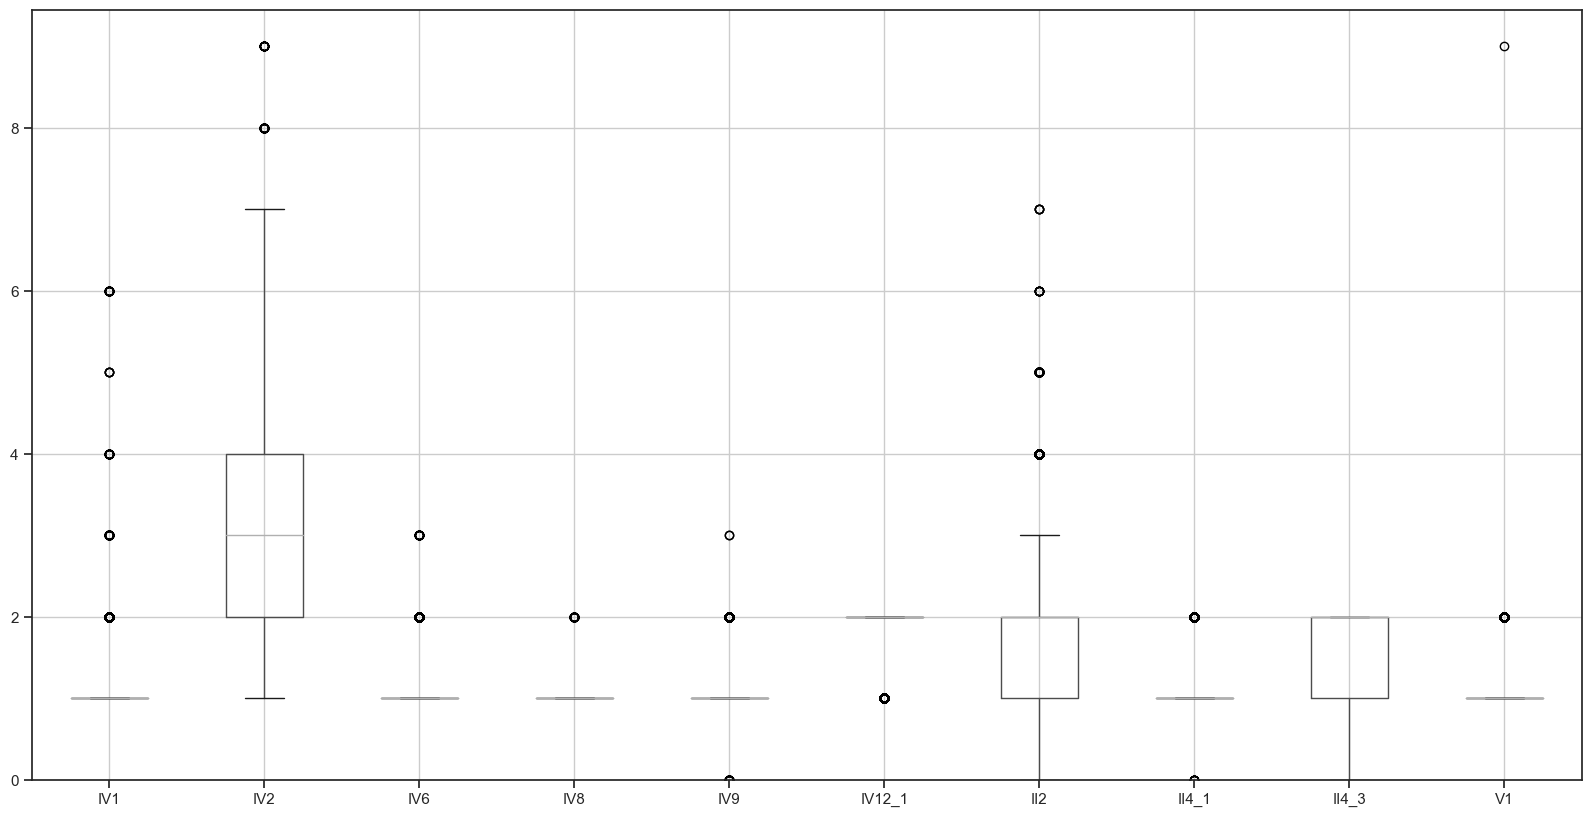

In [18]:
#2020
mean_IV2 = np.mean(var20.loc[var20['IV2'] != 99, 'IV2'])
var20.loc[var20['IV2'] == 99, 'IV2'] = mean_IV2
var20['IV2'].value_counts()
box_20=var20.drop(['ITF','IPCF','AGLOMERADO'],axis=1)
box_20.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

We will now look at the distributioon of our datasets.

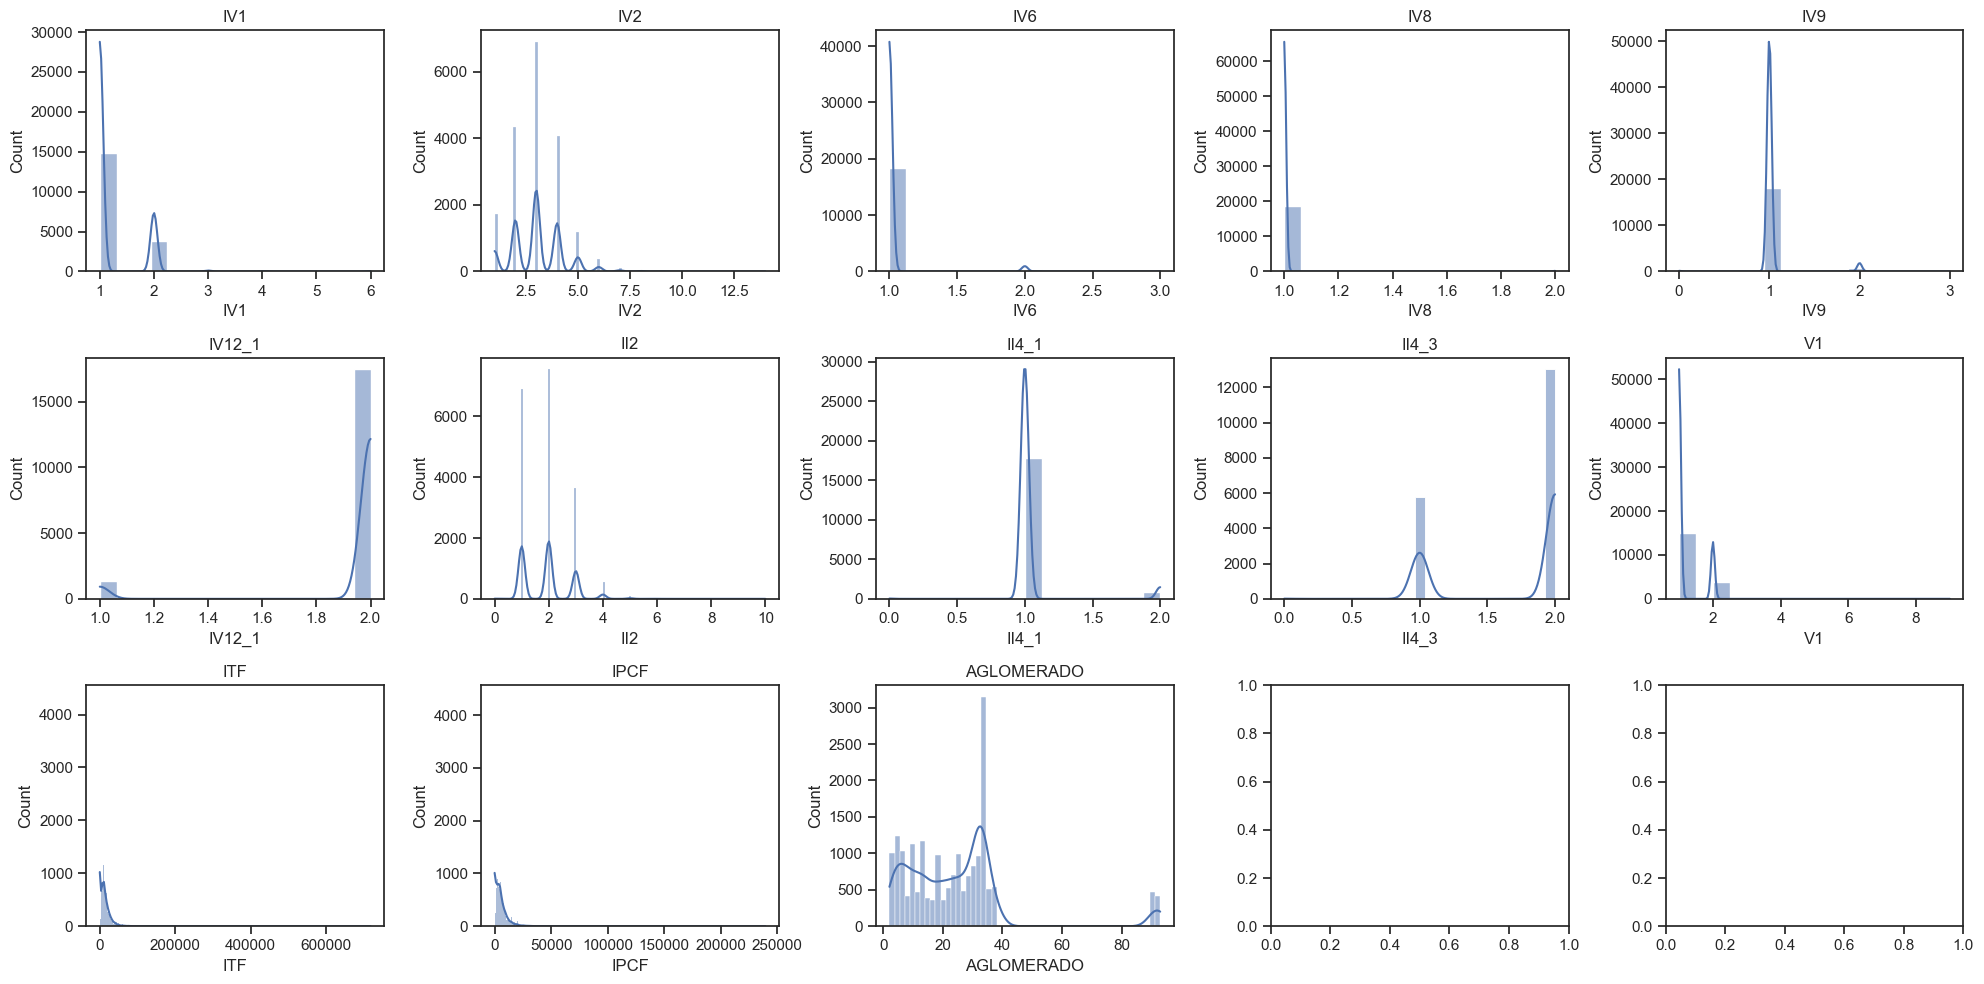

In [19]:
#2015
num_rows = 3
num_cols = 5
variable_names = list(var15.columns)
num_figures = len(variable_names)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, var_name in enumerate(variable_names):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.histplot(data=var15[var_name], ax=ax, kde=True)
    ax.set_title(var_name)
plt.tight_layout()
plt.show()

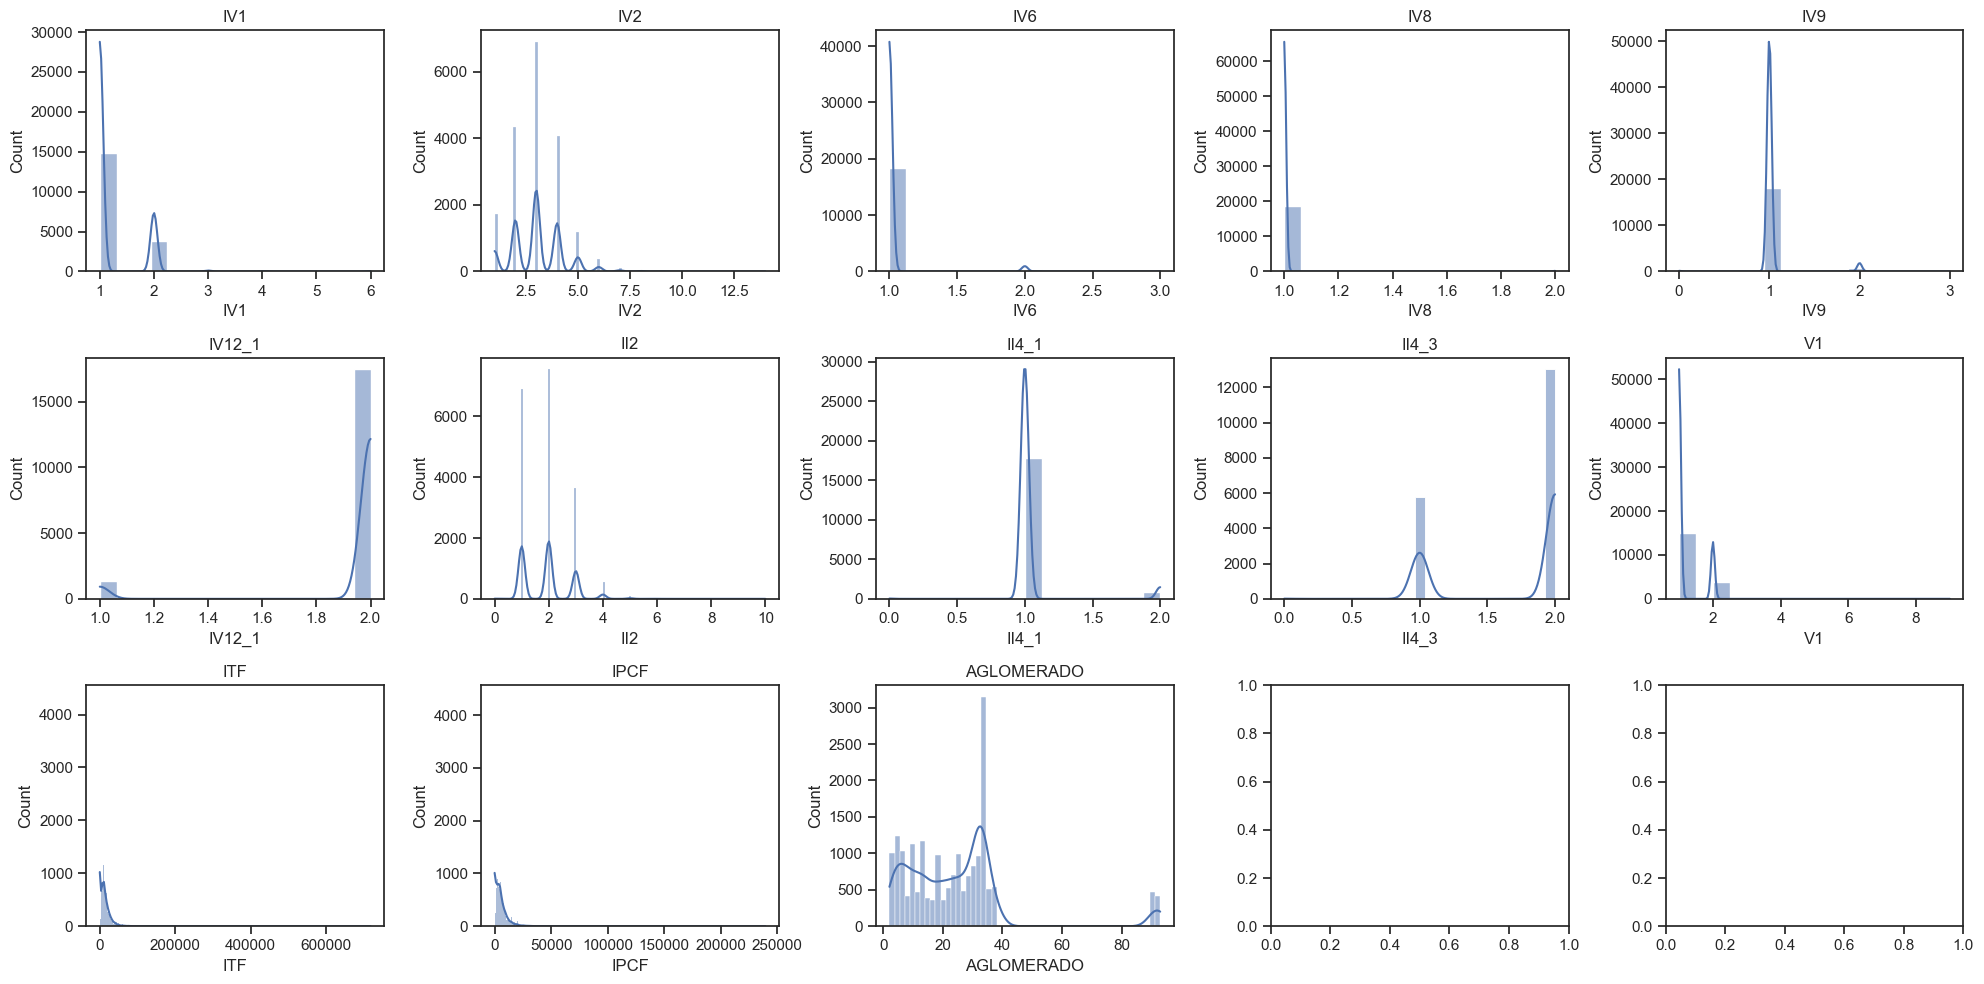

In [20]:
#2017
num_rows = 3
num_cols = 5
variable_names = list(var17.columns)
num_figures = len(variable_names)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, var_name in enumerate(variable_names):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.histplot(data=var15[var_name], ax=ax, kde=True)
    ax.set_title(var_name)
plt.tight_layout()
plt.show()

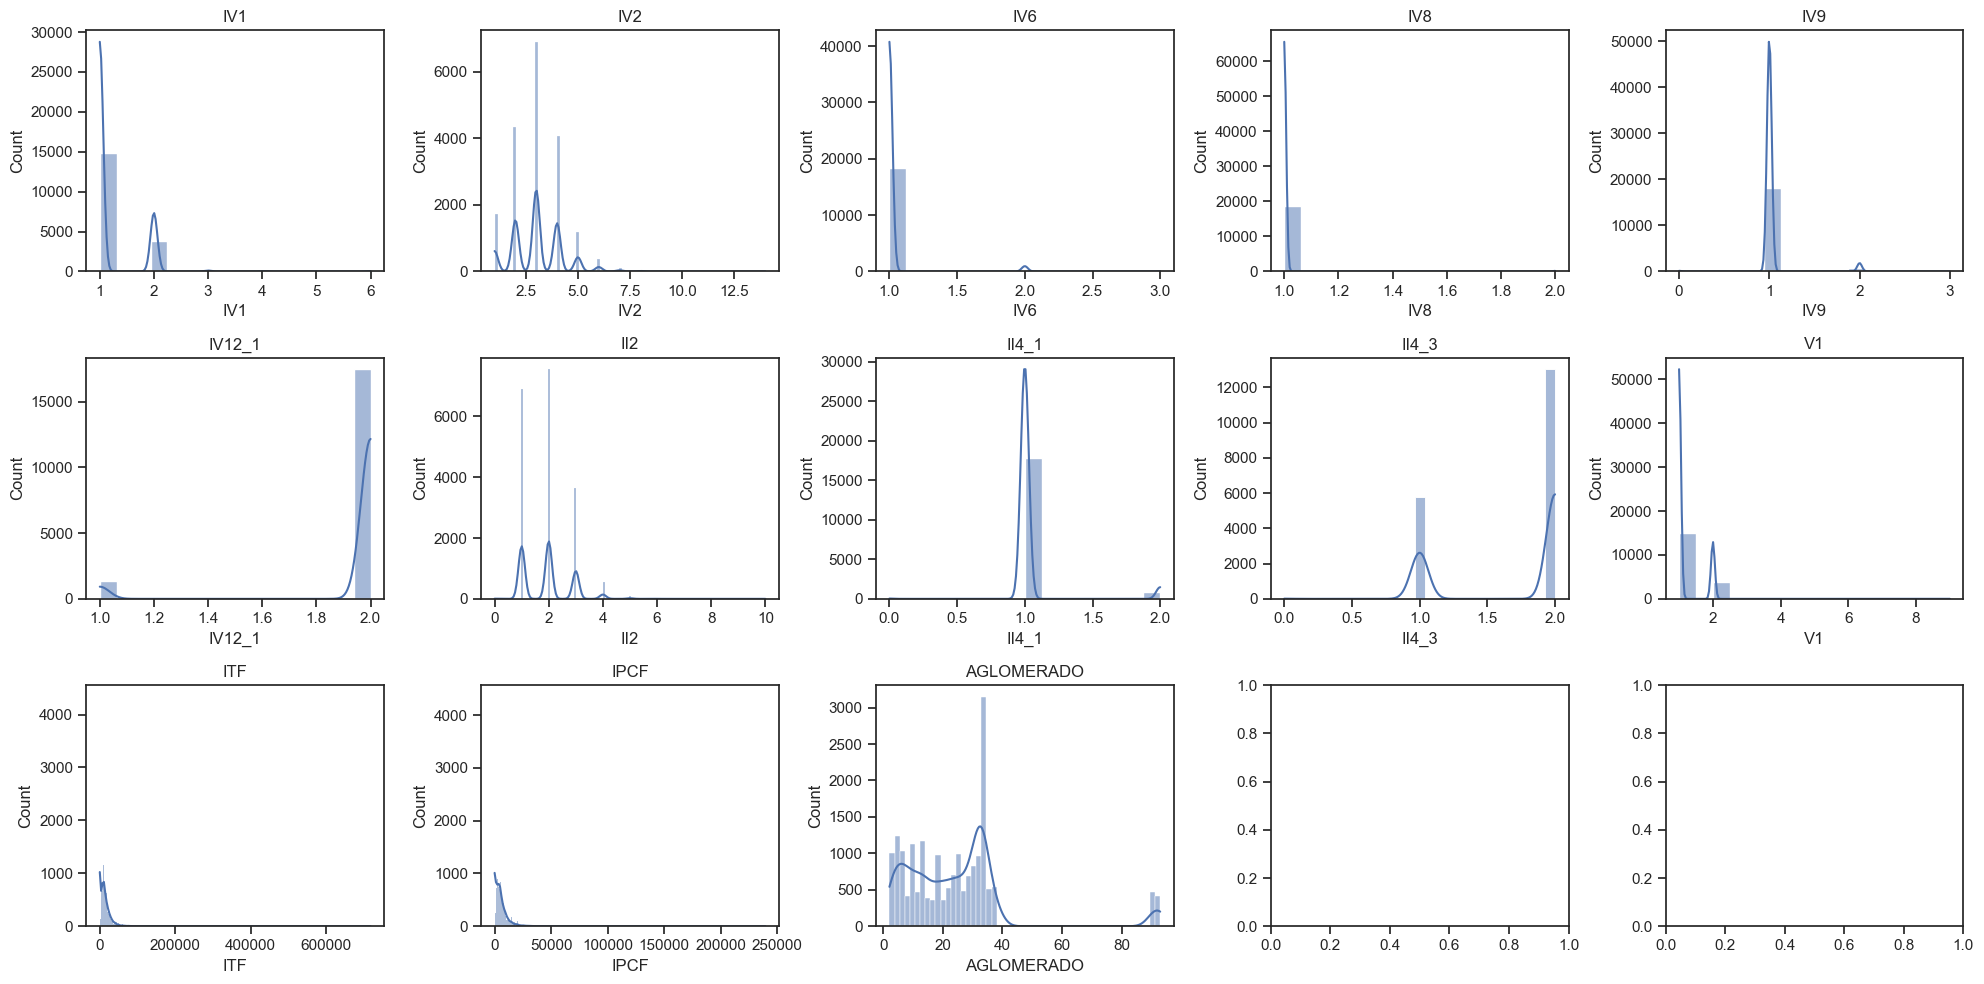

In [21]:
#2020
num_rows = 3
num_cols = 5
variable_names = list(var20.columns)
num_figures = len(variable_names)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, var_name in enumerate(variable_names):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.histplot(data=var15[var_name], ax=ax, kde=True)
    ax.set_title(var_name)
plt.tight_layout()
plt.show()

## 4.Preprocessing of data
Now in order to verify that variables are on the same scale, we will standardize the datasets. This is crucial for the clustering technique we will implement--> K-means.

And using the elbow method, which plots the inertia for different k-values and shows the "elbow point", we will see why using 3 clusters is optimal

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

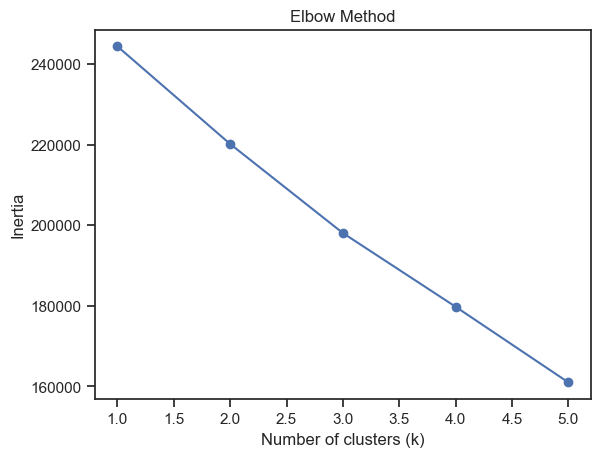

In [22]:
#2015
scaler = StandardScaler()
data_scaled_15 = scaler.fit_transform(var15)
inertia = []
k_values = list(range(1, 6))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_15)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

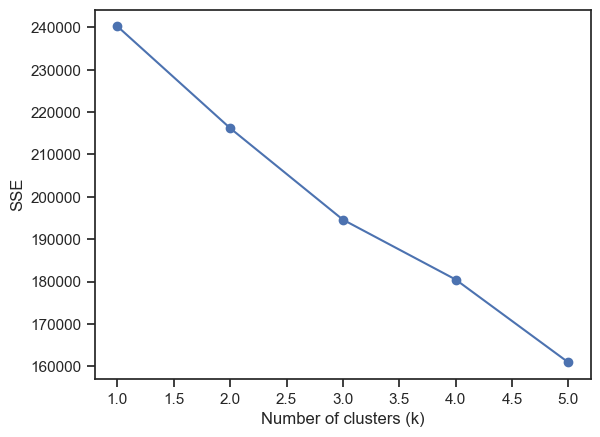

In [23]:
#2017
scaler = StandardScaler()
data_scaled_17 = scaler.fit_transform(var17)
inertia = []
k_values = list(range(1, 6))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_17)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('')
plt.show()

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

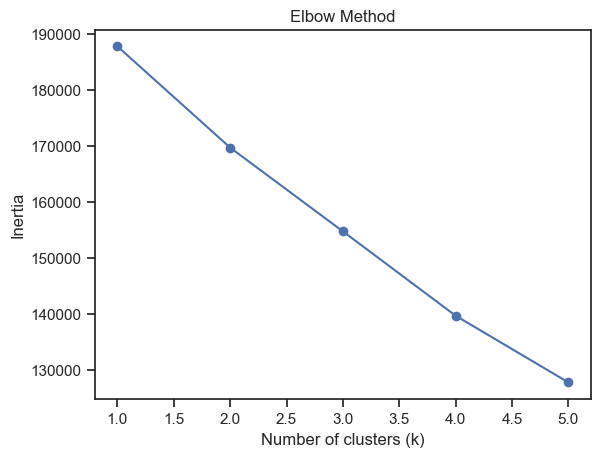

In [24]:
#2020
scaler = StandardScaler()
data_scaled_20 = scaler.fit_transform(var20)
inertia = []
k_values = list(range(1, 6))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_20)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Now we will separately perform the clustering and check the characteristics of the clusters for each year

We will perform 3 clusters using k-means and look at the count of each of these. Then, by looking at the mean of certain variables, we will establesh which cluster is 1:lower-class, 2:middle-class and 3:upper-class.

### 2015

In [26]:
var15_clustered = var15.copy()

In [31]:
k = 3 
kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300, random_state=42)
kmeans_clusters_15 = kmeans.fit_predict(data_scaled_15)


In [32]:
#Add the cluster labels to var15 and plot them against each variable
var15_clustered = var15.copy()
var15_clustered['cluster'] = kmeans_clusters_15
#sns.pairplot(var15_clustered, hue='cluster', diag_kind='hist')
#plt.show()

In [33]:
#Count of classes
var15_clustered['cluster'].value_counts()

2    10437
0     7915
1      444
Name: cluster, dtype: int64

In [34]:
#determine what cluster represents each social class by checking the mean family income
mean_income = var15_clustered.groupby('cluster')['ITF'].mean()
print(mean_income)

cluster
0    16551.916488
1     7835.387387
2    10005.337262
Name: ITF, dtype: float64


In [35]:
var15_clustered['cluster'] = var15_clustered['cluster'].replace({0:3, 1:1, 2:2})
var15_clustered['cluster'].value_counts()

2    10437
3     7915
1      444
Name: cluster, dtype: int64

In [36]:
var15_clustered['cluster'].value_counts()

2    10437
3     7915
1      444
Name: cluster, dtype: int64

### 2017

In [37]:
kmeans_clusters_17 = kmeans.fit_predict(data_scaled_17)

In [38]:
#Add the cluster labels to var17 and plot them against each variable
var17_clustered = var17.copy()
var17_clustered['cluster'] = kmeans_clusters_17
#sns.pairplot(var17_clustered, hue='cluster', diag_kind='hist')
#plt.show()

In [39]:
#Count of classes
var17_clustered['cluster'].value_counts()

1    15719
0     1504
2     1254
Name: cluster, dtype: int64

In [40]:
#determine what cluster represents each social class by checking the mean family income
mean_income = var17_clustered.groupby('cluster')['ITF'].mean()
print(mean_income)

cluster
0    12446.810505
1    17023.176729
2    15750.296651
Name: ITF, dtype: float64


In [41]:
var17_clustered['cluster'] = var17_clustered['cluster'].replace({0:1, 1:3, 2:2})
var17_clustered['cluster'].value_counts()

3    15719
1     1504
2     1254
Name: cluster, dtype: int64

### 2020

In [42]:
kmeans_clusters_20 = kmeans.fit_predict(data_scaled_20)
var20_clustered = var20.copy()

In [43]:
#Add the cluster labels to var20 and plot them against each variable
var20_clustered = var20.copy()
var20_clustered['cluster'] = kmeans_clusters_20
#sns.pairplot(var20_clustered, hue='cluster', diag_kind='hist')
#plt.show()

In [44]:
#Count of classes
var20_clustered['cluster'].value_counts()

0    8151
1    6019
2     272
Name: cluster, dtype: int64

In [45]:
#determine what cluster represents each social class by checking the mean family income
mean_income = var20_clustered.groupby('cluster')['ITF'].mean()
print(mean_income)

cluster
0    33460.538584
1    64589.970261
2    29040.680147
Name: ITF, dtype: float64


In [46]:
var20_clustered['cluster'] = var20_clustered['cluster'].replace({0:2, 1:3, 2:1})
var20_clustered['cluster'].value_counts()

2    8151
3    6019
1     272
Name: cluster, dtype: int64

### ALL TOGETHER

In [47]:
var15_clustered["Year"] = 2015
var17_clustered["Year"] = 2017
var20_clustered["Year"] = 2020
alt = pd.concat([var15_clustered, var17_clustered, var20_clustered], ignore_index=True)
alt

,IV1,IV2,IV6,IV8,IV9,IV12_1,II2,II4_1,II4_3,V1,ITF,IPCF,AGLOMERADO,cluster,Year
0,1,3.0,1,1,1,2,2,1,1,1,0,0.00,14,3,2015
1,1,3.0,1,1,1,2,2,1,1,1,19000,6333.33,14,3,2015
2,1,2.0,1,1,1,2,1,1,2,2,13800,6900.00,14,2,2015
3,1,4.0,1,1,1,2,1,1,1,1,25000,12500.00,14,3,2015
4,1,3.0,1,1,1,2,1,1,1,1,6000,3000.00,14,3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51710,2,1.0,1,1,2,2,1,1,2,1,30000,30000.00,13,2,2020
51711,2,1.0,1,1,1,2,1,1,2,2,11000,5500.00,13,2,2020
51712,2,3.0,1,1,1,2,1,1,2,2,15000,15000.00,13,2,2020
51713,2,1.0,1,1,1,2,1,1,2,1,48000,24000.00,13,2,2020


## 5. Save our results

In [48]:
arg = {
    "Year": [2015, 2017, 2020],
    "Lower_Class": [444,1504 , 272],
    "Middle_Class": [7915, 1254, 8151],
    "High_Class": [10437, 15719, 6019],
}

arg = pd.DataFrame(arg)
arg

,Year,Lower_Class,Middle_Class,High_Class
0,2015,444,7915,10437
1,2017,1504,1254,15719
2,2020,272,8151,6019


Export them to a csv file

In [ ]:
arg.to_csv('/Users/mac/Desktop/TFG/data/code/classes/arg.csv', index=False)

## 6. Merge with sexual harassment cases to gain insights

In [49]:
import pandas as pd

data = {'Year': [2015, 2017, 2020],
        'Sexual_Harassment_Cases': [12637, 10552, 20950]}
sh = pd.DataFrame(data)
sh


,Year,Sexual_Harassment_Cases
0,2015,12637
1,2017,10552
2,2020,20950


In [50]:
combined = pd.merge(alt, sh, on="Year")
combined

,IV1,IV2,IV6,IV8,IV9,IV12_1,II2,II4_1,II4_3,V1,ITF,IPCF,AGLOMERADO,cluster,Year,Sexual_Harassment_Cases
0,1,3.0,1,1,1,2,2,1,1,1,0,0.00,14,3,2015,12637
1,1,3.0,1,1,1,2,2,1,1,1,19000,6333.33,14,3,2015,12637
2,1,2.0,1,1,1,2,1,1,2,2,13800,6900.00,14,2,2015,12637
3,1,4.0,1,1,1,2,1,1,1,1,25000,12500.00,14,3,2015,12637
4,1,3.0,1,1,1,2,1,1,1,1,6000,3000.00,14,3,2015,12637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51710,2,1.0,1,1,2,2,1,1,2,1,30000,30000.00,13,2,2020,20950
51711,2,1.0,1,1,1,2,1,1,2,2,11000,5500.00,13,2,2020,20950
51712,2,3.0,1,1,1,2,1,1,2,2,15000,15000.00,13,2,2020,20950
51713,2,1.0,1,1,1,2,1,1,2,1,48000,24000.00,13,2,2020,20950


Lets take a closer look at each each cluster

Now we will see what variables had more importance for the cluster attribution using LASSO regression.

In [51]:
X = combined[['IV1', 'IV2', 'IV6', 'IV8', 'IV9', 'IV12_1', 'II2', 'II4_1', 'II4_3', 'V1', 'ITF', 'IPCF']]
y = combined['cluster']
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
coef = pd.Series(lasso.coef_, index=X.columns)
print("LASSO coefficients:")
print(coef.abs().sort_values())

LASSO coefficients:
IV1       0.000000
IV2       0.000000
IV6       0.000000
IV8       0.000000
IV9       0.000000
IV12_1    0.000000
II2       0.000000
II4_1     0.000000
II4_3     0.000000
V1        0.000000
ITF       0.000005
IPCF      0.000008
dtype: float64


In [52]:
time_series_data = combined.pivot_table(index="Year", columns="cluster", values="Sexual_Harassment_Cases")

for cluster in time_series_data.columns:
    model = ARIMA(time_series_data[cluster], order=(1, 1, 1))
    results = model.fit()
    print(f"Cluster {cluster}:")
    print(results.summary())
    print("Forecast for the next year:")
    print(results.forecast(steps=1))


/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users

Cluster 1:
                               SARIMAX Results                                
Dep. Variable:                      1   No. Observations:                    3
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -19.845
Date:                Thu, 04 May 2023   AIC                             45.691
Time:                        11:36:44   BIC                             41.770
Sample:                             0   HQIC                            37.492
                                  - 3                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.907     -1.103      0.270      -2.777       0.777
ma.L1          0.9853     49.732      0.020      0.984     -96.487      98.458
sigma2      1.801e+07   5.42e-08   3.32e+

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1327: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1339: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mac/opt/miniconda3/envs/tfg

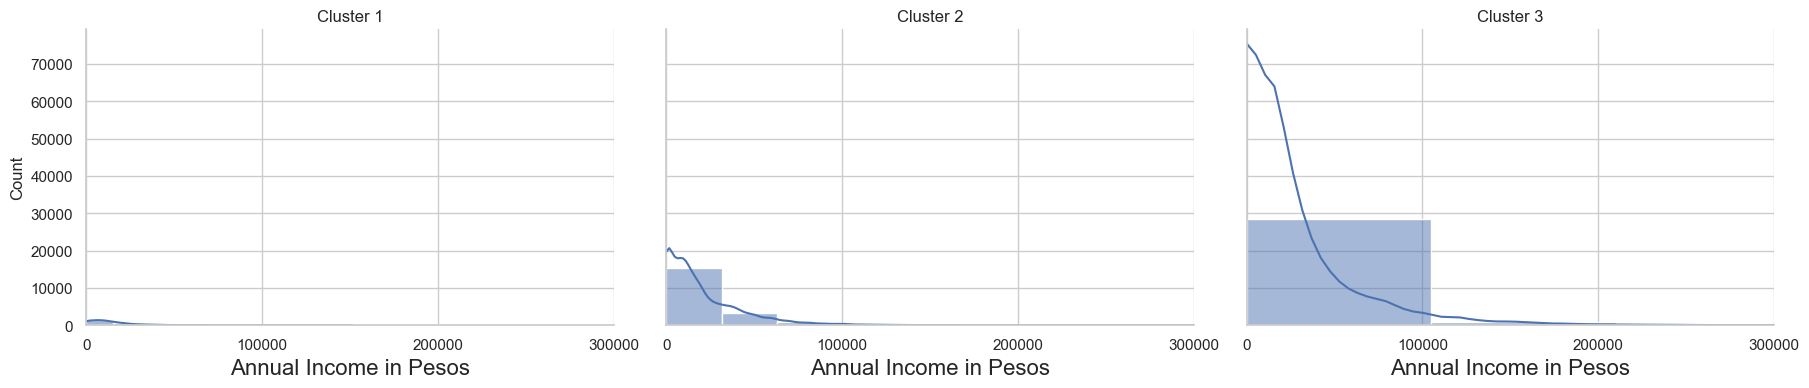

In [68]:
sns.set(style="whitegrid")
long_format_data = combined.melt(id_vars=['cluster'], value_vars=['ITF'])
g = sns.FacetGrid(long_format_data, col='cluster', row='variable', sharey='row', sharex='col', height=4, aspect=1.5)
g.map(sns.histplot, 'value', kde=True, bins=10)
g.set_titles("Cluster {col_name}")
g.set(xlim=(0, 300000))
g.set(xticks=np.linspace(0, 300000, 4))
g.set_xlabels('Annual Income in Pesos',fontsize=16)
plt.subplots_adjust(wspace=0.1)
plt.show()